<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

# Imports and settings

In [1]:
!pip install -U torchinfo gdown gshell

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.7 MB 7.4 MB/s 
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=f724952600db736bf4e8fd467dd9a42dbd0c544486933f218f1c7feb265a6af7
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
  Created wheel for gshell: filename=gshell-5.5.4-py3-none-any.whl size=5773519 sha256=271c1758aa6c5402c1142ffdacb7f5e5d6f68dad34d7fb0bb0db6062b4f338c3
  Stored in directory: /root/.cache/pip/wheels/90/47/14/4a354d97721718a2011e08740570211cb02cf5020703ea3597
Successfully built gdown gshell
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [26]:
import getpass
import itertools
import os
import pexpect
import pickle
import random
import shutil
import subprocess
import sys
import time
import zipfile

import gdown
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm.notebook as tqdm
%matplotlib inline

import skimage
import skimage.io
import skimage.transform

import sklearn
import sklearn.model_selection
import sklearn.manifold
import sklearn.metrics
import sklearn.neighbors
import sklearn.cluster
import sklearn.preprocessing

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import torchvision.transforms as tt
import torchvision.models as vision_models
import torchvision.utils as vision_utils
import torchvision.datasets as vision_datasets
import torchinfo

In [3]:
sns.set(style='darkgrid', font_scale=1.2)
plt.rcParams["figure.figsize"] = (20, 20)

# Setting random seeds for reproducibility

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

# Determining available device

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Setting globals

In [6]:
TRAIN_TIMES = []
BATCH_SIZE = 256
LATENT_SPACE_SIZE = 512
IMAGE_SIZE = 128
NORMALIZATION_PARAMS = (0, 0, 0), (0.5, 0.5, 0.5)
SAMPLE_DIR = "/content/sample_dir"

In [7]:
try:
    os.mkdir(SAMPLE_DIR)
except FileExistsError:
    pass # already exists

# Helper functions and classes

In [29]:
class FacesDataset(data_utils.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_names = sorted(list(os.listdir(self.img_dir)))
        self.transform = transform
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = skimage.img_as_float32(skimage.io.imread(img_path))
        if self.transform:
            image = self.transform(image)
        return image

In [30]:
def fit_epoch_discriminator(real, discriminator, generator, optimizer, criterion, batch_size, latent_size):
    try:
        optimizer.zero_grad()

        real_preds = discriminator(real)
        real_targets = torch.ones(real.size(0), 1, device=DEVICE)
        real_loss = criterion(real_preds, real_targets)
        real_score = torch.mean(real_preds).item()

        latent = torch.randn(batch_size, latent_size, device=DEVICE)
        fake = generator(latent)
        fake_preds = discriminator(fake)
        fake_targets = torch.zeros(fake.size(0), 1, device=DEVICE)
        fake_loss = criterion(fake_preds, fake_targets)
        fake_score = torch.mean(fake_preds).item()

        loss_discriminator = real_loss + fake_loss
        loss_discriminator.backward()
        optimizer.step()
    finally:
        real_targets, real_preds, fake_targets, fake_preds = \
        real_targets.cpu(), real_preds.cpu(), fake_targets.cpu(), fake_preds.cpu()
        del real_targets, real_preds, fake_targets, fake_preds
        torch.cuda.empty_cache()
    return loss_discriminator, real_score, fake_score

def fit_epoch_generator(generator, discriminator, optimizer, criterion, batch_size, latent_size):
    try:
        optimizer.zero_grad()
        latent = torch.randn(batch_size, latent_size, device=DEVICE)
        fake = generator(latent)
        preds = discriminator(fake)
        targets = torch.ones(batch_size, 1, device=DEVICE)
        loss_generator = criterion(preds, targets)
        loss_generator.backward()
        optimizer.step()
    finally:
        latent, preds, targets = latent.cpu(), preds.cpu(), targets.cpu()
        del latent, preds, targets
        torch.cuda.empty_cache()
    return loss_generator

In [31]:
def fit_epoch(data_train, models, optimizers, criteria, batch_size, latent_size):
    models["generator"].train()
    models["discriminator"].train()
    losses_discriminator = []
    losses_generator = []
    real_scores = []
    fake_scores = []
    for real in tqdm.tqdm(data_train, desc="Fitting"):
        try:
            real = real.to(DEVICE)

            loss_discriminator, real_score, fake_score = fit_epoch_discriminator(real, discriminator, generator, optimizers["discriminator"], criteria["discriminator"], batch_size, latent_size)
            losses_discriminator.append(loss_discriminator.item())
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            loss_generator = fit_epoch_generator(models["generator"], models["discriminator"], optimizers["generator"], criteria["generator"], batch_size, latent_size)
            losses_generator.append(loss_generator.item())
        finally:
            real = real.to("cpu")
            del real
            torch.cuda.empty_cache()
    return np.mean(losses_generator), np.mean(losses_discriminator), np.mean(real_scores), np.mean(fake_scores)
  
def train_model(data_train, models, optimizers, criteria, epochs, batch_size, latent_size, schedulers=None, start_epoch=0):
    history = []
    log_template = "\nEpoch {ep: 03d}, generator loss: {gen_loss: 0.4f}, \
    discriminator loss {disc_loss: 0.4f}, real score: {real_score: 0.4f}, \
    fake score: {fake_score: 0.4f}"

    prev_lr_g, prev_lr_d = optimizers["generator"].param_groups[0]["lr"], optimizers["discriminator"].param_groups[0]["lr"]

    start_time = time.time()

    with tqdm.tqdm(desc="Epoch", total=epochs) as pbar_outer:
        for epoch in range(start_epoch, epochs):
            try:
                gen_loss, disc_loss, real_score, fake_score = fit_epoch(data_train, models, optimizers, criteria, batch_size, latent_size)
                tqdm.tqdm.write(f"Generator loss: {gen_loss}")
                tqdm.tqdm.write(f"Discriminator loss: {disc_loss}")
                
                clear_output(wait=True)
                pbar_outer.update(1)
                tqdm.tqdm.write(log_template.format(ep=epoch + 1, gen_loss=gen_loss, \
                                                    disc_loss=disc_loss, real_score=real_score, \
                                                    fake_score=fake_score))
                if schedulers is not None:
                    if schedulers["generator"] is not None:
                        schedulers["generator"].step(disc_loss)
                    if schedulers["discriminator"] is not None:
                        schedulers["discriminator"].step(gen_loss)

                history.append((gen_loss, disc_loss, real_score, fake_score, optimizers["generator"].param_groups[0]["lr"], optimizers["discriminator"].param_groups[0]["lr"]))
            
                show_generated_train(generator, epoch, history[-1], batch_size, latent_size, sample_size=6)

                pbar_outer.refresh()

                if epoch == epochs - 1:
                    save_samples(generator, epoch, batch_size, latent_size)
            except KeyboardInterrupt as stop:
                tqdm.tqdm.write(f"Training interrupted at epoch {epoch + 1}. Returning history")
                return history
        
    end_time = time.time()
    train_time = end_time - start_time
    TRAIN_TIMES.append(train_time)
    tqdm.tqdm.write(f"Overall training time: {train_time: 0.1f} seconds")

    return history

In [32]:
def show_generated_train(generator, epoch, epoch_stats, batch_size, latent_size, sample_size=6):
    log_template = "{size} generated images on epoch {ep: 03d}.\n\
    Generator loss: {g_loss: 0.4f}, discriminator loss: {d_loss: 0.4f}\n\
    Real score: {r_score: 0.4f}, fake score: {f_score: 0.4f}"
    try:
        nrow = int(np.ceil(np.sqrt(batch_size)))
        latent = torch.randn(batch_size, latent_size, device=DEVICE)
        with torch.no_grad():
            output = generator(latent)
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(vision_utils.make_grid(denormalize_images(output.detach().cpu()), nrow=nrow).permute(1, 2, 0).numpy())
        plt.suptitle(log_template.format(size=sample_size, ep=epoch + 1, \
                                        g_loss=epoch_stats[0], d_loss=epoch_stats[1], \
                                        r_score=epoch_stats[2], f_score=epoch_stats[3]))
        plt.show()
    finally:
        latent, output = latent.to("cpu"), output.to("cpu")
        del latent, output
        torch.cuda.empty_cache()

def denormalize_images(images):
    return images * NORMALIZATION_PARAMS[1][0] + NORMALIZATION_PARAMS[0][0]

def save_samples(generator, epoch, batch_size, latent_size):
    try:
        nrow = int(np.ceil(np.sqrt(batch_size)))
        latent = torch.randn(batch_size, latent_size, device=DEVICE)
        with torch.no_grad():
            fake_images = generator(latent)
        fake_fname = f"generated-images-{epoch + 1}.png"
        vision_utils.save_image(denormalize_images(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=nrow)
        print(f"Saving generated images to {fake_fname}")
    finally:
        fake_images, latent = fake_images.cpu(), latent.cpu()
        del fake_images, latent
        torch.cuda.empty_cache()

def show_images(images, batch_size):
    nrow = int(np.ceil(np.sqrt(batch_size)))
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(vision_utils.make_grid(denormalize_images(images), nrow=nrow).permute(1, 2, 0).numpy())

def show_batch(loader, batch_size):
    for images in loader:
        show_images(images, batch_size)
        break

In [33]:
def plot_losses(history):
    gen_loss, disc_loss, _, _, _, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(gen_loss, "-", label="Generator loss")
    plt.plot(disc_loss, "-", label="Discriminator loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.title("Generator and discriminator losses during training")
    plt.show()

def plot_scores(history):
    _, _, real_score, fake_score, _, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(real_score, "-", label="Real images discriminator score")
    plt.plot(fake_score, "-", label="Fake images discriminator score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Discriminator scores for real and fake images during training")
    plt.show()

def plot_learn_rates(history):
    _, _, _, _, lr_gen, lr_disc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(lr_gen, "-", label="Generator learn rate")
    plt.plot(lr_disc, "-", label="Discriminator learn rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learn rate")
    plt.legend(loc="best")
    plt.title("Generator and discriminator learn rates during training")
    plt.show()

# Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [34]:
def download_with_credentials(filename):
    """
    Downloads the data from a copy made into one's Google Drive. Assumes that the filename is the same as the one used in path in download_and_prepare_dataset
    :param filename: filename to download
    :returns: None
    """
    print("Trying to download file from our Google Drive")
    init = pexpect.spawn("gshell init") # run process
    try:
        init.expect("Enter") # wait until we get a prompt
        print(init.before.decode("utf-8")) # show all output that went before the prompt
        init.sendline(getpass.getpass()) # get the auth code via getpass and send to the process
    except pexpect.EOF:
        # auth code already saved, gshell init is useless
        pass
    def download_progress(filename):
        with subprocess.Popen(["gshell", "download", filename]) as p:
            while p.poll() is None:
                # will be active until the process finishes
                yield
    it = tqdm.tqdm(download_progress(filename), desc="Downloading")
    for _ in it:
        # will at least produce an elapsed time
        if os.path.isfile(filename):
            # we have downloaded the file
            # (gshell gives incompletely downloaded file the .incomplete extension, so the file will get the expected name only after the download finishes)
            it.close()
            break

In [35]:
def resize_images(img_folder):
    """
    Resizes all images to a smaller size and overwrites them.
    :param img_folder: path to dataset folder
    :returns: None
    """
    for file in tqdm.tqdm(os.listdir(img_folder), desc="Resizing images"):
        image = skimage.img_as_ubyte(skimage.io.imread(os.path.join(os.path.abspath(img_folder), file)))
        image = skimage.transform.resize(image, (IMAGE_SIZE, IMAGE_SIZE), anti_aliasing=True)
        os.remove(os.path.join(os.path.abspath(img_folder), file))
        skimage.io.imsave(skimage.img_as_float32(os.path.join(os.path.abspath(img_folder)), file), image)

In [36]:
def download_and_prepare_dataset(url="https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing", path="/content/faces_dataset_small.zip", transform=None):
    """
    Downloads the data from Google Drive, deletes erroneously created folders and returns a custom Dataset with specified transforms
    :param url: Google Drive file url
    :param path: Path where to download the dataset archive
    :returns: FacesDataset object
    """
    root, fname = os.path.split(os.path.abspath(path))
    folder_name, _ = os.path.splitext(fname)
    img_folder = os.path.join(root, folder_name)
    try:
        if not (os.path.isfile(path) or os.path.isdir(folder_name)): # the archive or the folder already exist
                gdown.cached_download(url=url, path=path, quiet=False, fuzzy=True, use_cookies=False)
    except FileNotFoundError: # spawns on cached_download failure
        # google drive limits downloads of large files, so we use gshell to force download of a file stored on our own google drive
        # this assumes the file has the same name.
        download_with_credentials(fname)
    if os.path.isfile(path): # unpack the archive if it exists
        shutil.rmtree(img_folder, ignore_errors=True) # clear out old data
        with zipfile.ZipFile(path, 'r') as archive:
            for member in tqdm.tqdm(archive.infolist(), desc="Extracting files"):
                archive.extract(member, root)
        os.remove(path) # delete the archive
    shutil.rmtree(os.path.join(root, "__MACOSX"), ignore_errors=True) # someone uses MacOS...
    shutil.rmtree(os.path.join(img_folder, "04000"), ignore_errors=True) # empty dir for some reason
    try:
        os.remove(os.path.join(img_folder, ".DS_Store")) # MacOS special file (not an image)
    except FileNotFoundError:
        pass # already deleted
    image_test = skimage.io.imread(os.path.join(img_folder, os.listdir(img_folder)[0]))
    if image_test.shape[0] != IMAGE_SIZE or image_test.shape[1] != IMAGE_SIZE:
        resize_images(img_folder)
    dataset = FacesDataset(img_folder, transform=transform)
    return dataset

In [37]:
def get_dataloader(batch_size, **kwargs):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and width of the image
  :param batch_size: batch_size of the dataloader
  :param **kwargs: arguments to be passed to download_and_prepare_dataset
  :returns: DataLoader object 
  """
  dataset = download_and_prepare_dataset(**kwargs)
  loader = data_utils.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True, drop_last=True)
  return loader

In [38]:
loader = get_dataloader(BATCH_SIZE, 
                        url="https://drive.google.com/file/d/1uemDS2f29m3SrrfgclrGSiLFgZZX4sDC/view?usp=sharing",
                        transform=tt.Compose([
                                            tt.ToPILImage(),
                                            tt.Resize(IMAGE_SIZE), 
                                            tt.CenterCrop(IMAGE_SIZE), 
                                            tt.ToTensor(), 
                                            tt.Normalize(*NORMALIZATION_PARAMS)
                                            ])
                        )

In [20]:
next(iter(loader)).shape

torch.Size([256, 3, 128, 128])

In [ ]:
show_images(next(iter(loader)), 64)

# Часть 2. Построение и обучение модели (2 балла)

## Defining architectures

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
def weights_init(module):
    """
    The DCGAN paper (https://arxiv.org/abs/1511.06434v2) defines layer initialization as normal distribution with mean=0, stddev=0.02
    This function reinitializes all convolutional and batchnorm layers using these parameters.
    :param module: layer (of type nn.Module)
    """
    classname = module.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant(module.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.init_size = IMAGE_SIZE // 4
        self.delinearizer = nn.Sequential(
            nn.Linear(LATENT_SPACE_SIZE, 128 * self.init_size ** 2),
            nn.Unflatten(dim=1, unflattened_size=(128, self.init_size, self.init_size))
        )
        self.convs = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        unflattened = self.delinearizer(input)
        return self.convs(unflattened)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.downsampled_size = IMAGE_SIZE // 2 ** 4
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, momentum=0.8),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.Flatten(start_dim=1)
        )
        self.linear = nn.Sequential(
            nn.Linear(128 * self.downsampled_size ** 2, 1),
            nn.Sigmoid()
            )
    
    def forward(self, input):
        flat = self.convs(input)
        return self.linear(flat)

In [ ]:
generator = Generator().to(DEVICE)

In [ ]:
torchinfo.summary(generator, (BATCH_SIZE, LATENT_SPACE_SIZE))

In [ ]:
discriminator = Discriminator().to(DEVICE)

In [ ]:
torchinfo.summary(discriminator, (BATCH_SIZE, 3, 128, 128))

In [ ]:
!nvidia-smi

## Training DCGAN

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
models = {
    "discriminator": discriminator,
    "generator": generator
}

criteria = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizers = {
    "discriminator": torch.optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
}

schedulers = {
    "discriminator": None,
    "generator": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers["generator"], mode="max", patience=5, threshold=1e-3, cooldown=5, verbose=True)
}

In [8]:
max_epochs = 50
history_gan = train_model(loader, models, optimizers, criteria, max_epochs, BATCH_SIZE, LATENT_SPACE_SIZE, schedulers=schedulers)

NameError: ignored

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [9]:
plot_losses(history_gan)

NameError: ignored

In [10]:
plot_scores(history_gan)

NameError: ignored

In [ ]:
plot_learn_rates(history_gan)

# Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

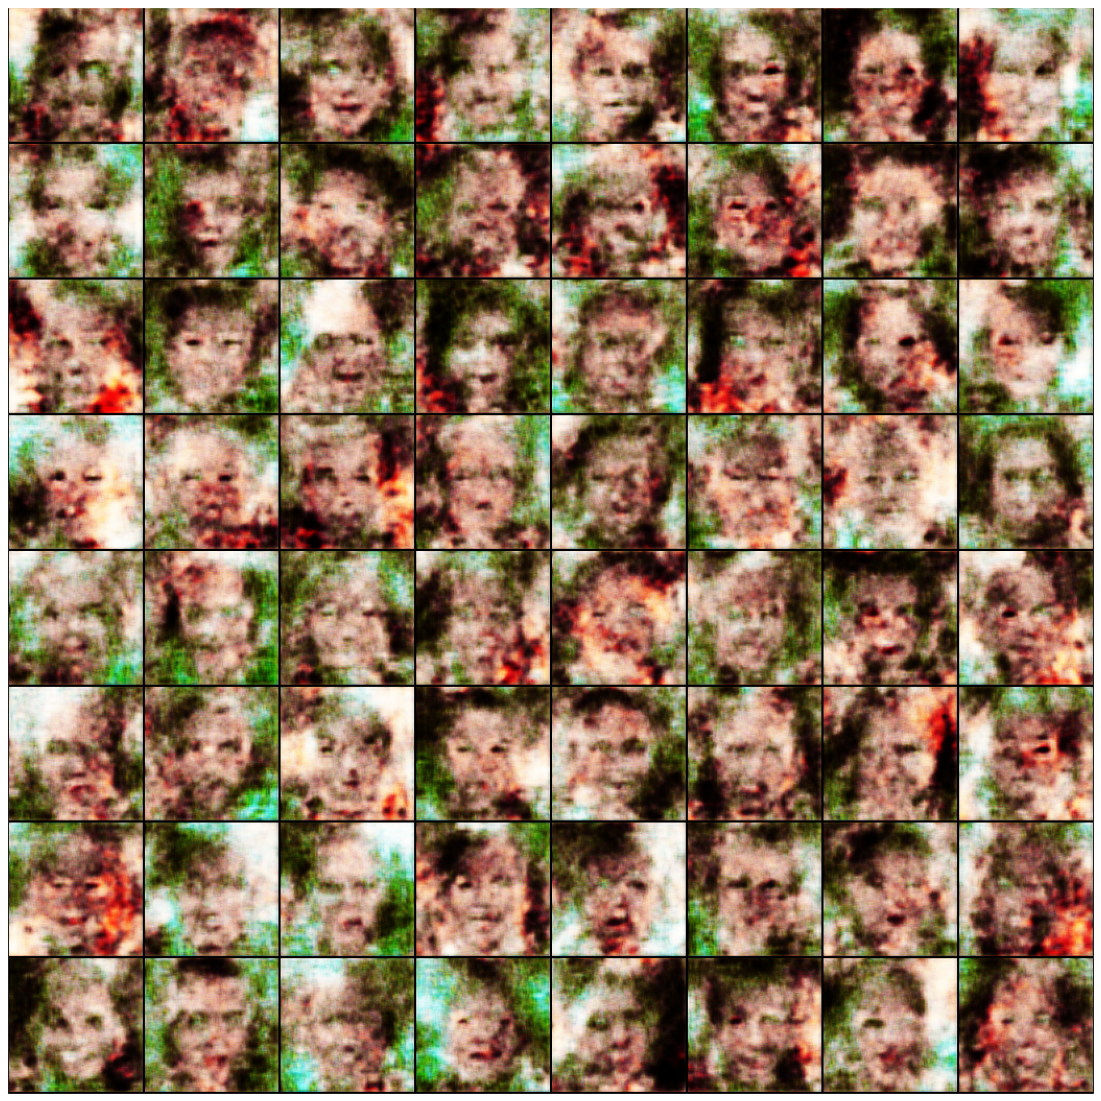

In [46]:
n_images = 4
fixed_latent = torch.randn(BATCH_SIZE, LATENT_SPACE_SIZE, device=DEVICE)
with torch.no_grad():
    fake_images = models["generator"](fixed_latent).detach().cpu()
fixed_latent = fixed_latent.cpu()
del fixed_latent
torch.cuda.empty_cache()
show_images(fake_images, BATCH_SIZE)

Как вам качество получившихся изображений?

# Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [53]:
def generate_fakes(loader, generator, batch_size, latent_size):
    generator.eval()
    fakes = []
    for real in tqdm.tqdm(loader, desc="Generating fakes"):
        try:
            latent = torch.randn(BATCH_SIZE, LATENT_SPACE_SIZE, device=DEVICE)
            with torch.no_grad():
                outputs = generator(latent).detach().cpu()
            fakes.append(outputs)
        finally:
            latent = latent.cpu()
            del latent
            torch.cuda.empty_cache()
    return torch.flatten(torch.stack(fakes), end_dim=1)

In [56]:
real = torch.flatten(torch.stack([i for i in tqdm.tqdm(loader, desc="Loading real images")]), end_dim=1)
fakes = generate_fakes(loader, models["generator"], BATCH_SIZE, LATENT_SPACE_SIZE)

Loading real images: 0it [00:00, ?it/s]

Generating fakes:   0%|          | 0/50 [00:00<?, ?it/s]

In [59]:
X = torch.flatten(torch.stack([real, fakes]), end_dim=1).numpy()
y = torch.flatten(torch.stack([torch.Tensor([1 for i in real]), torch.Tensor([0 for i in fakes])]), end_dim=1).numpy()

In [ ]:
one_nn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
loo = sklearn.model_selection.LeaveOneOut()
for train_idx, test_idx in loo.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
    y_train, y_test = y_train.reshape, y_test
    print(X_train.shape)
    one_nn.fit(X_train, y_train)
    y_pred = one_nn.predict(X_train)
    print(sklearn.metrics.accuracy(y_test, y_pred))

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
real_compressed = sklearn.manifold.TSNE(n_components=2, verbose=1).fit_transform(real.numpy())
print("[t-SNE] Done.")

In [ ]:
fakes_compressed = sklearn.manifold.TSNE(n_components=2, verbose=1).fit_transform(fakes.numpy())
print("[t-SNE] Done.")

In [ ]:
def plot_latent_compressed(data, targets, num_classes=2):
    plt.figure(figsize=(20, 10))
    d = {i:[] for i in range(num_classes)}
    
    for j in range(num_classes):
        if j in targets:
            mask = (targets == j)
            d[j].append(data[mask])

    colors = list(matplotlib.colors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(d[i][:, 0], d[i][:, 1], c=colors[i][1], label=f"{"real" if i else "fake"}", alpha=0.5)
        
    kmeans = sklearn.cluster.KMeans(n_clusters=num_classes)
    X = np.concatenate(list(d.values()))
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    for i, center in enumerate(centroids):
        plt.text(center[0], center[1], str(i), fontdict={"size": 20, "weight": "bold"})
        
    plt.title("Real/fake pictures distribution")
    plt.colorbar()
    plt.legend()
    plt.plot();

Прокомментируйте получившийся результат: